# 01.01 - PROYECTO KAGGLE

In [35]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

replicating local resources


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 357MB/s]


## unzip and inspect data

In [3]:
!unzip udea*.zip > /dev/null

In [ ]:
!wc *.csv

   296787    296787   4716673 submission_example.csv
   296787   4565553  59185238 test.csv
   692501  10666231 143732437 train.csv
  1286075  15528571 207634348 total


## load `train.csv` data with pandas



In [182]:
import pandas as pd
import numpy as np

z = pd.read_csv("train.csv")
print ("shape of loaded dataframe", z.shape)


shape of loaded dataframe (692500, 21)


Vista dataset

En esta sección se muestran las primeras filas del dataset usando z.head(), lo que permite revisar rápidamente la estructura y los datos cargados.

In [183]:
z.head()

,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,...,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_TIENEINTERNET.1,F_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,...,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,...,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,...,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,...,N,No,Si,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,...,N,No,Si,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294


Columnas a evaluar

columnas del dataset para trabajar solo con `'F_TIENEINTERNET'`, `'F_EDUCACIONMADRE'`, `'E_VALORMATRICULAUNIVERSIDAD'` y `'RENDIMIENTO_GLOBAL'`. Luego, con `z.head()` se muestra una vista previa de estas columnas seleccionadas.

In [184]:
z = z[['F_TIENEINTERNET', 'F_EDUCACIONMADRE', 'F_EDUCACIONPADRE', 'E_VALORMATRICULAUNIVERSIDAD', 'RENDIMIENTO_GLOBAL']]
z.head()

,F_TIENEINTERNET,F_EDUCACIONMADRE,F_EDUCACIONPADRE,E_VALORMATRICULAUNIVERSIDAD,RENDIMIENTO_GLOBAL
0,Si,Postgrado,Técnica o tecnológica incompleta,Entre 5.5 millones y menos de 7 millones,medio-alto
1,No,Técnica o tecnológica incompleta,Técnica o tecnológica completa,Entre 2.5 millones y menos de 4 millones,bajo
2,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,Entre 2.5 millones y menos de 4 millones,bajo
3,Si,Secundaria (Bachillerato) completa,No sabe,Entre 4 millones y menos de 5.5 millones,alto
4,Si,Primaria completa,Primaria completa,Entre 2.5 millones y menos de 4 millones,medio-bajo


<Axes: xlabel='F_TIENEINTERNET'>

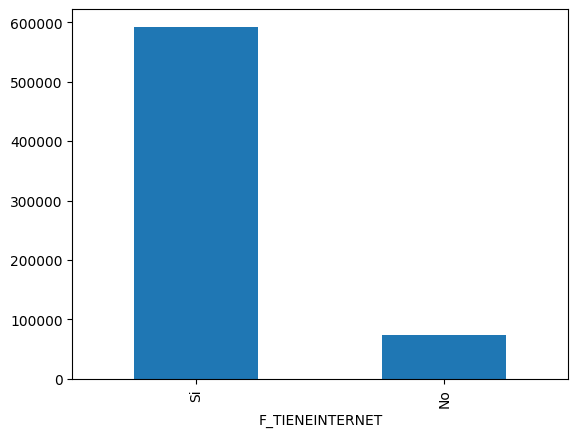

In [185]:
z.F_TIENEINTERNET	.value_counts().plot(kind='bar')

<Axes: xlabel='F_EDUCACIONPADRE'>

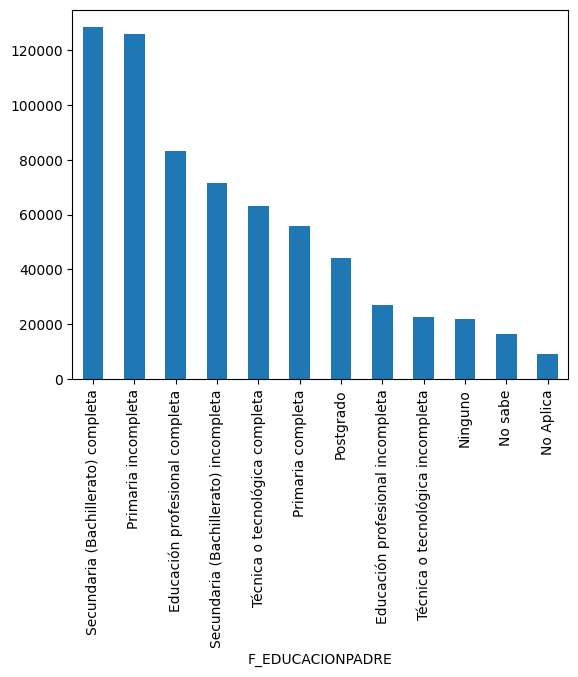

In [186]:
z.F_EDUCACIONPADRE.value_counts().plot(kind='bar')

<Axes: xlabel='F_EDUCACIONMADRE'>

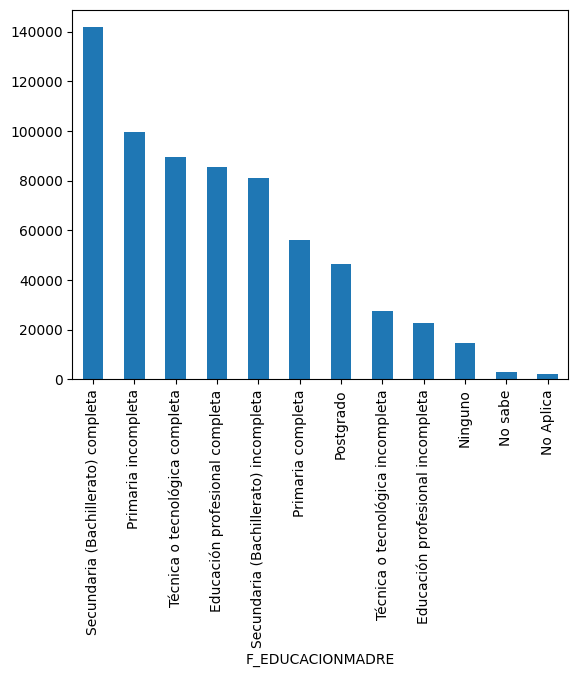

In [187]:
z.F_EDUCACIONMADRE.value_counts().plot(kind='bar')

<Axes: xlabel='E_VALORMATRICULAUNIVERSIDAD'>

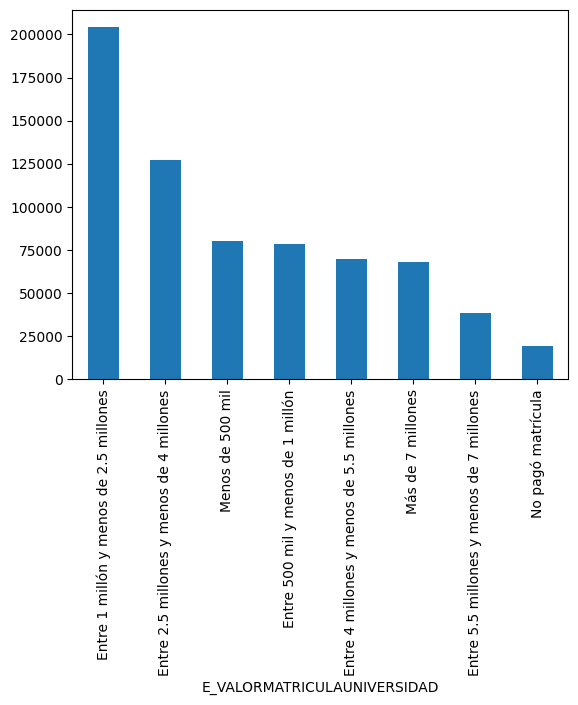

In [188]:
z.E_VALORMATRICULAUNIVERSIDAD.value_counts().plot(kind='bar')

cómo se distribuye el rendimiento académico general, representado por la columna 'RENDIMIENTO_GLOBAL', en relación con los diferentes costos de matrícula universitaria ('E_VALORMATRICULAUNIVERSIDAD'). A través de gráficos de barras, visualizamos la frecuencia de cada nivel de rendimiento ('bajo', 'medio-bajo', 'medio-alto' y 'alto') dentro de cada categoría de valor de matrícula. Esto nos ayuda a identificar si existen relaciones o tendencias entre cuánto pagan los estudiantes de matrícula y su desempeño académico."

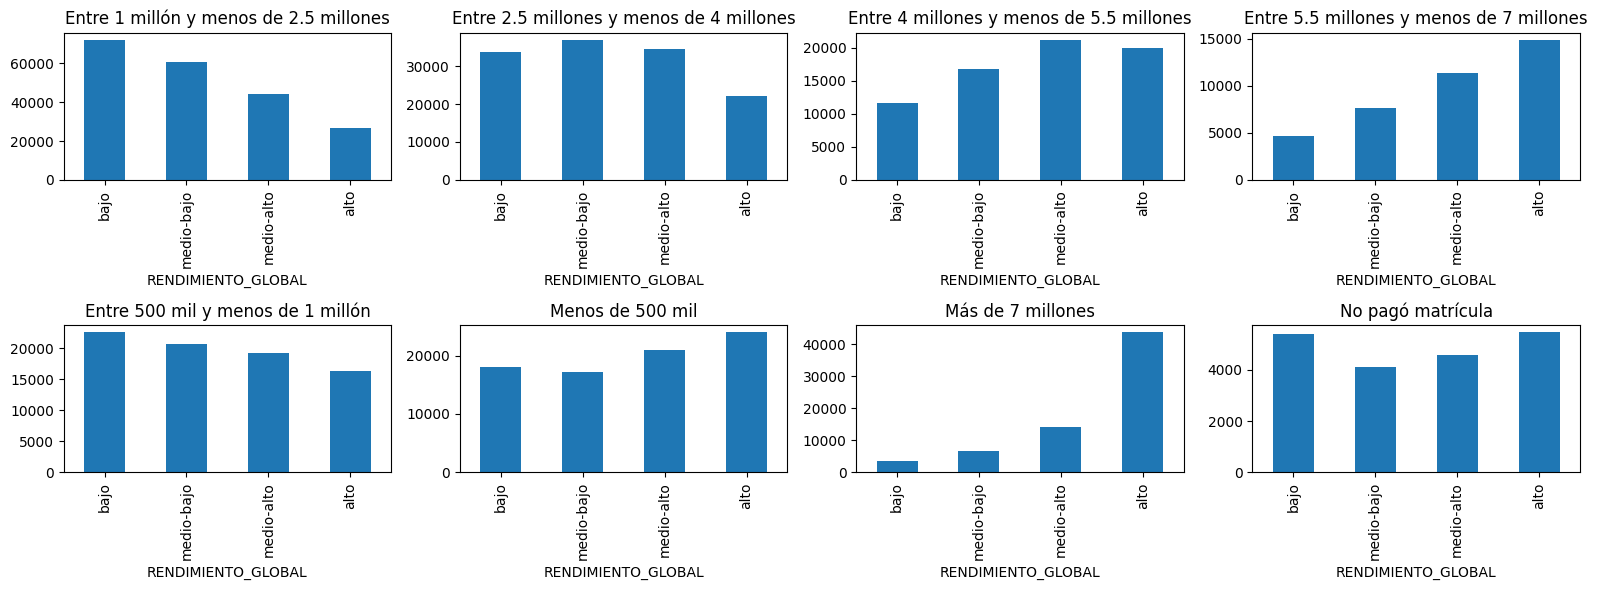

In [189]:
from rlxutils import subplots
import matplotlib.pyplot as plt

c = sorted(z.E_VALORMATRICULAUNIVERSIDAD.value_counts().index)
for ax,ci in subplots(c, n_cols=4, usizex=4):
    zc = z[z.E_VALORMATRICULAUNIVERSIDAD==ci]
    zc.RENDIMIENTO_GLOBAL.value_counts()[['bajo', 'medio-bajo', 'medio-alto', 'alto']].plot(kind='bar')
    plt.title(ci)

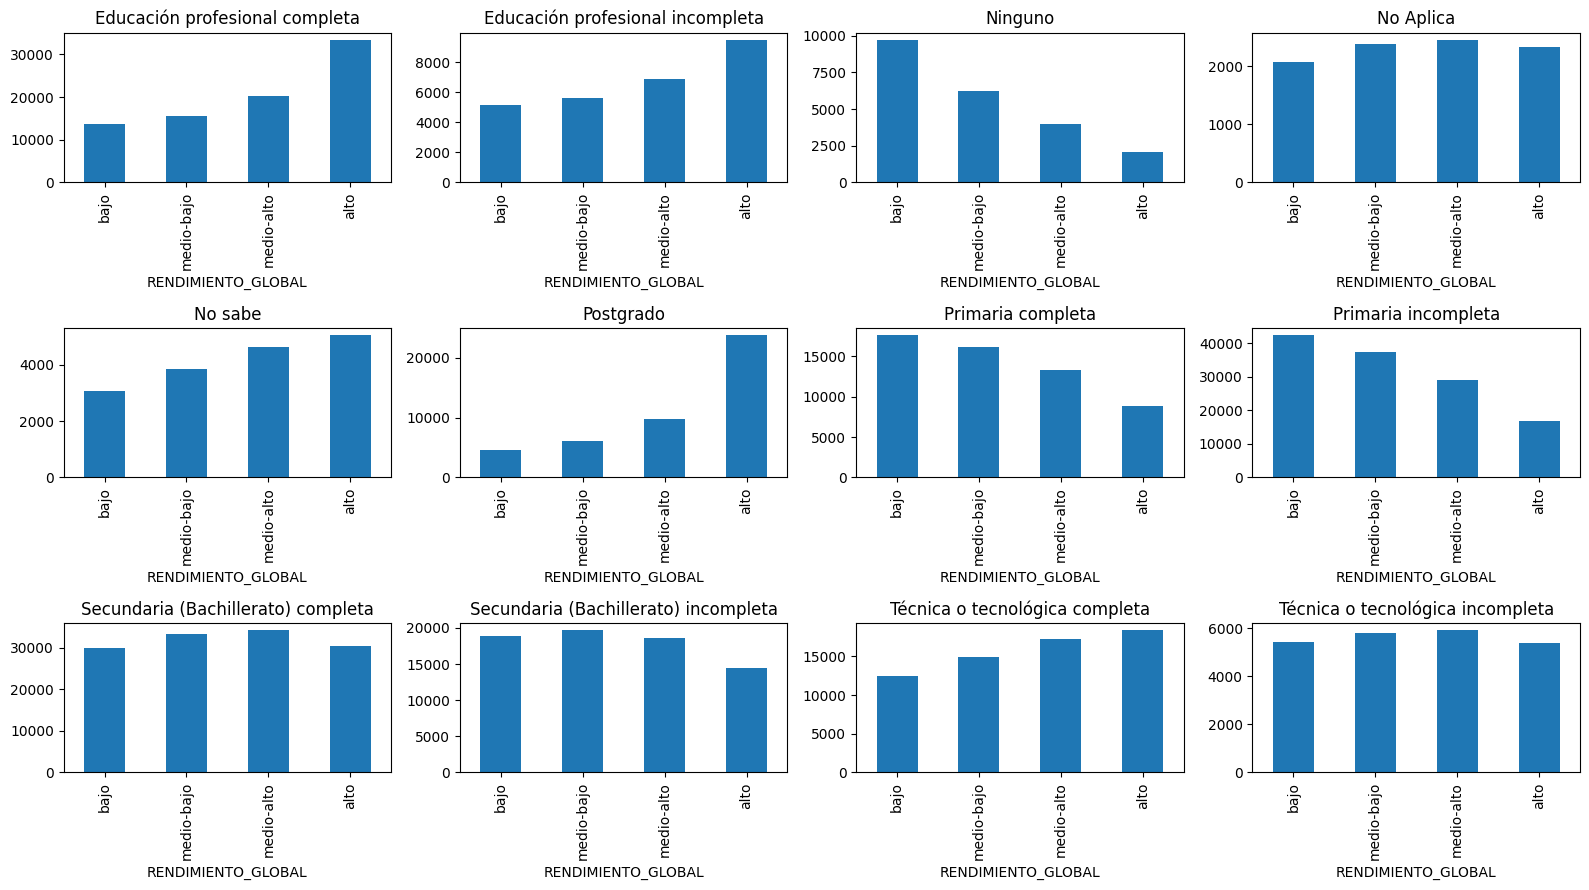

In [190]:
c = sorted(z.F_EDUCACIONPADRE.value_counts().index)
for ax,ci in subplots(c, n_cols=4, usizex=4):
    zc = z[z.F_EDUCACIONPADRE==ci]
    zc.RENDIMIENTO_GLOBAL.value_counts()[['bajo', 'medio-bajo', 'medio-alto', 'alto']].plot(kind='bar')
    plt.title(ci)

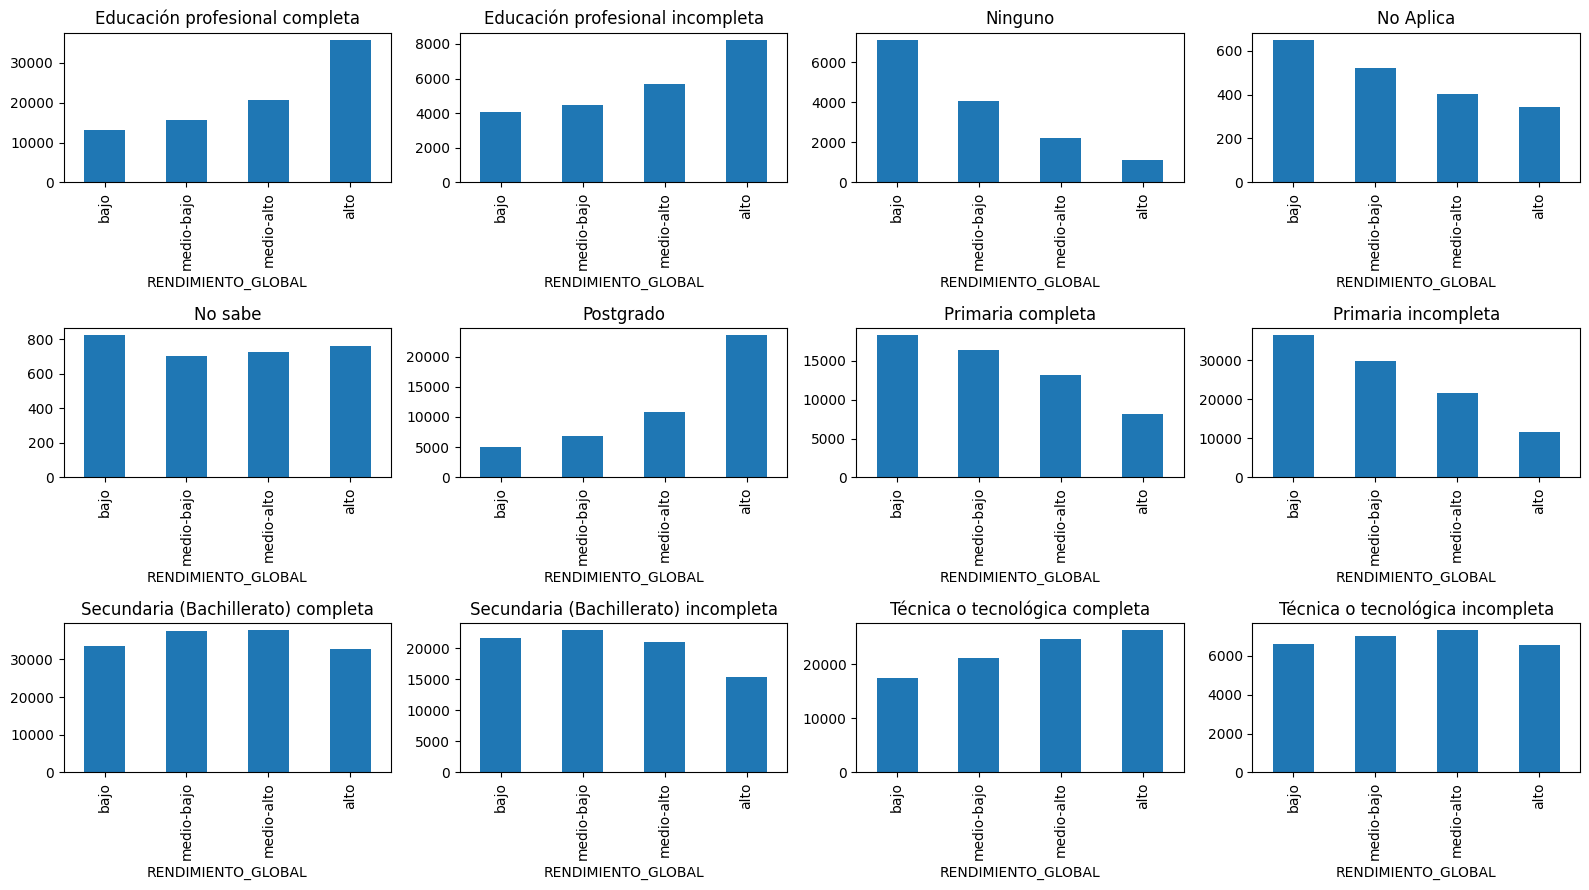

In [191]:
c = sorted(z.F_EDUCACIONMADRE.value_counts().index)
for ax,ci in subplots(c, n_cols=4, usizex=4):
    zc = z[z.F_EDUCACIONMADRE==ci]
    zc.RENDIMIENTO_GLOBAL.value_counts()[['bajo', 'medio-bajo', 'medio-alto', 'alto']].plot(kind='bar')
    plt.title(ci)

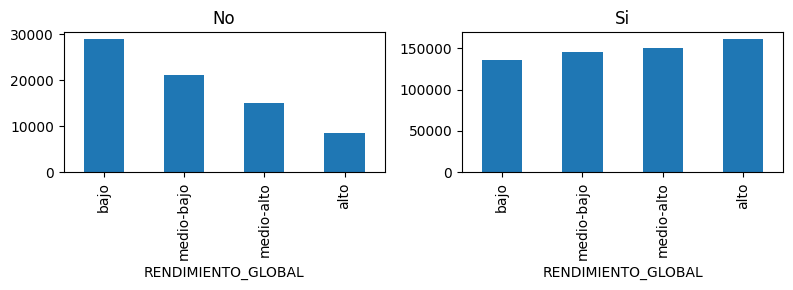

In [192]:
c = sorted(z.F_TIENEINTERNET.value_counts().index)
for ax,ci in subplots(c, n_cols=4, usizex=4):
    zc = z[z.F_TIENEINTERNET==ci]
    zc.RENDIMIENTO_GLOBAL.value_counts()[['bajo', 'medio-bajo', 'medio-alto', 'alto']].plot(kind='bar')
    plt.title(ci)

## LIMPIAR DATOS FALTANTES

In [201]:
sum(z.F_EDUCACIONMADRE.isna()), sum(z.E_VALORMATRICULAUNIVERSIDAD.isna())

(0, 0)

In [200]:
z.F_EDUCACIONMADRE.values[z.F_EDUCACIONMADRE.isna()] = 'N/A'
z.E_VALORMATRICULAUNIVERSIDAD.values[z.E_VALORMATRICULAUNIVERSIDAD.isna()] = 'N/A'
sum(z.F_EDUCACIONMADRE.isna()), sum(z.E_VALORMATRICULAUNIVERSIDAD.isna())

(0, 0)

Conversión de valores categóricos a numéricos
En esta sección se transforma la columna 'E_VALORMATRICULAUNIVERSIDAD' de categorías textuales a valores numéricos según un mapa (cmap) definido previamente.
Esto permite trabajar con los valores de matrícula de manera cuantitativa en análisis posteriores, como gráficos o estadísticas.
Luego se verifica la distribución de los valores convertidos con value_counts().

In [202]:
cmap = {'Entre 1 millón y menos de 2.5 millones': 1.75,
 'Entre 2.5 millones y menos de 4 millones': 3.25,
 'Menos de 500 mil': .250,
 'Entre 500 mil y menos de 1 millón': .75,
 'Entre 4 millones y menos de 5.5 millones': 4.75,
 'Más de 7 millones': 7.75,
 'Entre 5.5 millones y menos de 7 millones': 6.25,
 'No pagó matrícula': 0,
 'N/A': -1}

z.E_VALORMATRICULAUNIVERSIDAD = np.r_[[cmap[i] for i in z.E_VALORMATRICULAUNIVERSIDAD]]
z.E_VALORMATRICULAUNIVERSIDAD.value_counts()

,count
E_VALORMATRICULAUNIVERSIDAD,
1.75,204048
3.25,127430
0.25,80263
0.75,78704
4.75,69736
7.75,68014
6.25,38490
0.00,19528
-1.00,6287


Limpieza de categorías en educación de la madre
En esta sección se reemplazan valores poco informativos o ambiguos en 'F_EDUCACIONMADRE' ('No sabe' y 'No Aplica') por 'no info'.
Luego se verifica la distribución de las categorías limpias con value_counts() para asegurarse de que los datos estén consistentes.


In [203]:
z = z.copy()
z.F_EDUCACIONMADRE = ['no info' if i in ['No sabe', 'No Aplica'] else i for i in z.F_EDUCACIONMADRE.values]

 Conversión de la codificación one-hot a DataFrame
En esta sección se convierte el array de codificación one-hot de 'F_EDUCACIONMADRE' en un DataFrame de pandas.
Cada columna recibe un nombre descriptivo correspondiente a la categoría original, lo que facilita su integración con el dataset principal y su uso en análisis o modelos de machine learning.

In [204]:
x = z.F_EDUCACIONMADRE.values
F_EDUCACIONMADRE_vals = sorted(np.unique(x))
F_EDUCACIONMADRE_onehot_vals = {val: np.eye(len(F_EDUCACIONMADRE_vals))[i] for i,val in enumerate(F_EDUCACIONMADRE_vals)}
F_EDUCACIONMADRE_onehot_vals

{'Educación profesional completa': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Educación profesional incompleta': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'N/A': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Ninguno': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Postgrado': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 'Primaria completa': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 'Primaria incompleta': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 'Secundaria (Bachillerato) completa': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 'Secundaria (Bachillerato) incompleta': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 'Técnica o tecnológica completa': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 'Técnica o tecnológica incompleta': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 'no info': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])}

In [205]:
F_EDUCACIONMADRE_onehot_enc = np.r_[[F_EDUCACIONMADRE_onehot_vals[i] for i in z.F_EDUCACIONMADRE]]
F_EDUCACIONMADRE_onehot_enc

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [206]:
F_EDUCACIONMADRE_df = pd.DataFrame(F_EDUCACIONMADRE_onehot_enc, columns=[f"F_EDUCACIONMADRE__{v}" for v in F_EDUCACIONMADRE_onehot_vals])
F_EDUCACIONMADRE_df

,F_EDUCACIONMADRE__Educación profesional completa,F_EDUCACIONMADRE__Educación profesional incompleta,F_EDUCACIONMADRE__N/A,F_EDUCACIONMADRE__Ninguno,F_EDUCACIONMADRE__Postgrado,F_EDUCACIONMADRE__Primaria completa,F_EDUCACIONMADRE__Primaria incompleta,F_EDUCACIONMADRE__Secundaria (Bachillerato) completa,F_EDUCACIONMADRE__Secundaria (Bachillerato) incompleta,F_EDUCACIONMADRE__Técnica o tecnológica completa,F_EDUCACIONMADRE__Técnica o tecnológica incompleta,F_EDUCACIONMADRE__no info
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
692495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
692496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
692497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
692498,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [207]:
z = pd.concat([F_EDUCACIONMADRE_df, z], axis=1).drop('F_EDUCACIONMADRE', axis=1)
z.shape

(692500, 16)

In [208]:
z.head()

,F_EDUCACIONMADRE__Educación profesional completa,F_EDUCACIONMADRE__Educación profesional incompleta,F_EDUCACIONMADRE__N/A,F_EDUCACIONMADRE__Ninguno,F_EDUCACIONMADRE__Postgrado,F_EDUCACIONMADRE__Primaria completa,F_EDUCACIONMADRE__Primaria incompleta,F_EDUCACIONMADRE__Secundaria (Bachillerato) completa,F_EDUCACIONMADRE__Secundaria (Bachillerato) incompleta,F_EDUCACIONMADRE__Técnica o tecnológica completa,F_EDUCACIONMADRE__Técnica o tecnológica incompleta,F_EDUCACIONMADRE__no info,F_TIENEINTERNET,F_EDUCACIONPADRE,E_VALORMATRICULAUNIVERSIDAD,RENDIMIENTO_GLOBAL
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Si,Técnica o tecnológica incompleta,6.25,medio-alto
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,No,Técnica o tecnológica completa,3.25,bajo
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Si,Secundaria (Bachillerato) completa,3.25,bajo
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Si,No sabe,4.75,alto
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Si,Primaria completa,3.25,medio-bajo


En esta sección se convierte la columna 'RENDIMIENTO_GLOBAL' de categorías textuales a valores numéricos utilizando un mapa (rmap) definido previamente: 'bajo' → 0, 'medio-bajo' → 1, 'medio-alto' → 2, 'alto' → 3.
Esto permite usar la columna como variable dependiente en análisis cuantitativos o modelos de machine learning.
Se muestra una vista previa del dataset con z.head().

In [209]:
y_col = 'RENDIMIENTO_GLOBAL'

rmap = {'alto': 3, 'bajo':0, 'medio-bajo':1, 'medio-alto':2}
z[y_col] = [rmap[i] for i in z[y_col]]
z.head()

,F_EDUCACIONMADRE__Educación profesional completa,F_EDUCACIONMADRE__Educación profesional incompleta,F_EDUCACIONMADRE__N/A,F_EDUCACIONMADRE__Ninguno,F_EDUCACIONMADRE__Postgrado,F_EDUCACIONMADRE__Primaria completa,F_EDUCACIONMADRE__Primaria incompleta,F_EDUCACIONMADRE__Secundaria (Bachillerato) completa,F_EDUCACIONMADRE__Secundaria (Bachillerato) incompleta,F_EDUCACIONMADRE__Técnica o tecnológica completa,F_EDUCACIONMADRE__Técnica o tecnológica incompleta,F_EDUCACIONMADRE__no info,F_TIENEINTERNET,F_EDUCACIONPADRE,E_VALORMATRICULAUNIVERSIDAD,RENDIMIENTO_GLOBAL
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Si,Técnica o tecnológica incompleta,6.25,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,No,Técnica o tecnológica completa,3.25,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Si,Secundaria (Bachillerato) completa,3.25,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Si,No sabe,4.75,3
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Si,Primaria completa,3.25,1




En esta sección se ordenan las columnas del dataset y se separan las features (X) de la variable objetivo (y).
X contiene todas las columnas excepto 'RENDIMIENTO_GLOBAL' y y contiene los valores codificados de 'RENDIMIENTO_GLOBAL'.
Se verifica la forma de ambos arrays con X.shape y y.shape para asegurarse de que la separación se realizó correctamente.

In [224]:
from sklearn.model_selection import train_test_split

# División del dataset en entrenamiento y prueba (80% - 20%)
Xtr, Xts, ytr, yts = train_test_split(X, y, train_size=0.8)

# Verificación de la forma de los conjuntos resultantes
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((554000, 15), (138500, 15), (554000,), (138500,))

sección que divide el dataset en conjuntos de entrenamiento y prueba utilizando train_test_split de scikit-learn.
Se reserva el 80 % de los datos para entrenamiento (Xtr, ytr) y el 20 % restante para prueba (Xts, yts).
Se verifica la forma de cada conjunto con Xtr.shape, Xts.shape, ytr.shape y yts.shape para asegurarse de que la división se realizó correctamente.

In [225]:
from sklearn.model_selection import train_test_split

In [226]:
Xtr, Xts, ytr, yts = train_test_split(X,y, train_size=0.8)
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((554000, 15), (138500, 15), (554000,), (138500,))

En esta parte, preparamos nuestro modelo. Utilizamos la herramienta LogisticRegression de la biblioteca scikit-learn para crear un modelo de regresión logística. Luego, "entrenamos" este modelo usando nuestros datos de entrenamiento (etiquetados como Xtr y ytr). Al hacer esto, el modelo aprende a reconocer patrones en los datos para poder predecir resultados futuros cuando le demos nuevos datos (como los del conjunto de prueba)

get accuracy and confusion matrices

In [233]:
from sklearn.metrics import confusion_matrix

observe how each row in the confusion matrix adds up to 1. What does this mean?

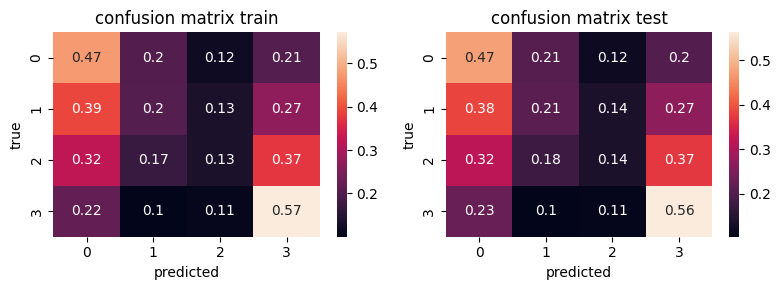

In [ ]:
import seaborn as sns
for ax,i in subplots(2, usizex=4):
  if i==0: sns.heatmap(cm_tr, annot=True); plt.title("confusion matrix train")
  if i==1: sns.heatmap(cm_ts, annot=True); plt.title("confusion matrix test")
  plt.ylabel("true")
  plt.xlabel("predicted")

## is the column `F_EDUCACIONMADRE` really contributing?

remove it and compare scores

In [ ]:
zh = z[['E_VALORMATRICULAUNIVERSIDAD', y_col]]

X = zh[[c for c in zh.columns if c!=y_col]].values
y = zh[y_col].values
X.shape, y.shape

((692500, 1), (692500,))

In [ ]:
Xtr, Xts, ytr, yts = train_test_split(X,y, train_size=0.8)
lr_small = LogisticRegression()
lr_small.fit(Xtr, ytr)

LogisticRegression()

In [ ]:
preds_tr = lr_small.predict(Xtr)
preds_ts = lr_small.predict(Xts)
np.mean(preds_tr==ytr), np.mean(preds_ts==yts)

(np.float64(0.3177075812274368), np.float64(0.31735018050541514))

Primero se calcula la precisión (accuracy) en los conjuntos de entrenamiento y prueba con np.mean(preds==y).
Luego se genera la matriz de confusión (confusion_matrix) para ambos conjuntos y se normaliza por clase, permitiendo observar la proporción de predicciones correctas por categoría.
Finalmente, se visualizan las matrices de confusión usando seaborn.heatmap para una interpretación más clara de los resultados.



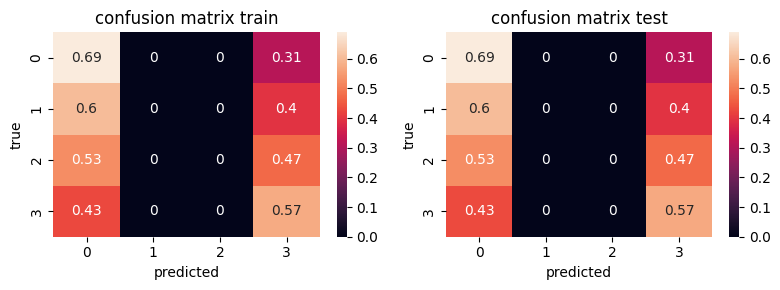

In [ ]:
cm_tr = confusion_matrix(ytr, preds_tr)
cm_ts = confusion_matrix(yts, preds_ts)

# normalize by class
cm_tr = cm_tr / cm_tr.sum(axis=1).reshape(-1,1)
cm_ts = cm_ts / cm_ts.sum(axis=1).reshape(-1,1)

import seaborn as sns
for ax,i in subplots(2, usizex=4):
  if i==0: sns.heatmap(cm_tr, annot=True); plt.title("confusion matrix train")
  if i==1: sns.heatmap(cm_ts, annot=True); plt.title("confusion matrix test")
  plt.ylabel("true")
  plt.xlabel("predicted")

En esta sección se realiza un análisis similar al modelo completo, pero utilizando únicamente la columna 'E_VALORMATRICULAUNIVERSIDAD' como feature.
Se separan las features y la variable objetivo, se dividen los datos en conjuntos de entrenamiento y prueba (80 %-20 %), y se entrena un modelo de regresión logística (lr_small).
Se generan predicciones para ambos conjuntos y se calcula la precisión (accuracy).
Finalmente, se crean y normalizan las matrices de confusión, que se visualizan con seaborn.heatmap para evaluar cómo el rendimiento académico puede predecirse usando solo el valor de matrícula.

In [ ]:
zt = pd.read_csv("test.csv")
zt

,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_TIENEINTERNET.1,F_EDUCACIONMADRE,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
0,550236,20183,TRABAJO SOCIAL,BOLIVAR,Menos de 500 mil,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica completa,Si,No,N,Si,Si,Si,Primaria completa,0.328,0.219,0.317,0.247
1,98545,20203,ADMINISTRACION COMERCIAL Y DE MERCADEO,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Si,No,N,No,Si,Si,Técnica o tecnológica completa,0.227,0.283,0.296,0.324
2,499179,20212,INGENIERIA MECATRONICA,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,0,Estrato 3,Si,Secundaria (Bachillerato) incompleta,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,0.285,0.228,0.294,0.247
3,782980,20195,CONTADURIA PUBLICA,SUCRE,Entre 1 millón y menos de 2.5 millones,Entre 21 y 30 horas,Estrato 1,No,Primaria incompleta,Si,No,N,No,No,No,Primaria incompleta,0.160,0.408,0.217,0.294
4,785185,20212,ADMINISTRACION DE EMPRESAS,ATLANTICO,Entre 2.5 millones y menos de 4 millones,Entre 11 y 20 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,0.209,0.283,0.306,0.286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296781,496981,20195,ADMINISTRACION DE EMPRESAS,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 1,Si,Primaria incompleta,Si,Si,N,Si,Si,Si,Primaria incompleta,0.168,0.410,0.235,0.300
296782,209415,20183,DERECHO,META,Entre 1 millón y menos de 2.5 millones,0,Estrato 4,Si,Educación profesional completa,Si,No,N,No,Si,Si,Educación profesional completa,0.471,0.184,0.264,0.193
296783,239074,20212,DERECHO,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,No,N,No,Si,Si,Educación profesional completa,0.292,0.249,0.276,0.256
296784,963852,20195,INGENIERIA AERONAUTICA,ANTIOQUIA,Entre 5.5 millones y menos de 7 millones,Entre 11 y 20 horas,Estrato 3,Si,Educación profesional completa,Si,No,N,No,Si,Si,Educación profesional completa,0.305,0.219,0.310,0.260


En esta sección se carga el dataset de prueba desde un archivo CSV (test.csv) y se seleccionan las columnas necesarias ('FAMI_EDUCACIONMADRE' y 'E_VALORMATRICULAUNIVERSIDAD').
Se manejan los valores faltantes reemplazándolos por 'no info'.
La columna 'E_VALORMATRICULAUNIVERSIDAD' se convierte a valores numéricos usando el mapa definido previamente (cmap).
Se limpian las categorías ambiguas en 'F_EDUCACIONMADRE' y se aplica la codificación one-hot usando los vectores definidos previamente (F_EDUCACIONMADRE_onehot_vals).
Finalmente, se concatena la codificación one-hot al dataset de prueba y se elimina la columna original, dejando zt listo para predicciones.

In [ ]:
zt_ids = zt['ID'].values
zt = zt[['F_EDUCACIONMADRE', 'E_VALORMATRICULAUNIVERSIDAD']]
print ("shape of loaded dataframe", zt.shape)
zt.head()

shape of loaded dataframe (296786, 2)


,F_EDUCACIONMADRE,E_VALORMATRICULAUNIVERSIDAD
0,Primaria completa,Menos de 500 mil
1,Técnica o tecnológica completa,Entre 2.5 millones y menos de 4 millones
2,Secundaria (Bachillerato) completa,Entre 1 millón y menos de 2.5 millones
3,Primaria incompleta,Entre 1 millón y menos de 2.5 millones
4,Secundaria (Bachillerato) completa,Entre 2.5 millones y menos de 4 millones


In [ ]:
zt.F_EDUCACIONMADRE.values[zt.F_EDUCACIONMADRE.isna()] = 'no info'
zt.E_VALORMATRICULAUNIVERSIDAD.values[zt.E_VALORMATRICULAUNIVERSIDAD.isna()] = 'no info'


In [ ]:
zt = zt.copy()
zt.E_VALORMATRICULAUNIVERSIDAD = np.r_[[cmap[i] for i in zt.E_VALORMATRICULAUNIVERSIDAD]]


In [ ]:
zt.F_EDUCACIONMADRE = ['no info' if i in ['No sabe', 'No Aplica'] else i for i in zt.F_EDUCACIONMADRE.values]
F_EDUCACIONMADRE_onehot_enc = np.r_[[F_EDUCACIONMADRE_onehot_vals[i] for i in zt.F_EDUCACIONMADRE]]
F_EDUCACIONMADRE_df = pd.DataFrame(F_EDUCACIONMADRE_onehot_enc, columns=[f"F_EDUCACIONMADRE__{v}" for v in F_EDUCACIONMADRE_onehot_vals])
zt = pd.concat([F_EDUCACIONMADRE_df, zt], axis=1).drop('F_EDUCACIONMADRE', axis=1)
zt.shape

(296786, 12)

In [ ]:
zt

,F_EDUCACIONMADRE__Educación profesional completa,F_EDUCACIONMADRE__Educación profesional incompleta,F_EDUCACIONMADRE__Ninguno,F_EDUCACIONMADRE__Postgrado,F_EDUCACIONMADRE__Primaria completa,F_EDUCACIONMADRE__Primaria incompleta,F_EDUCACIONMADRE__Secundaria (Bachillerato) completa,F_EDUCACIONMADRE__Secundaria (Bachillerato) incompleta,F_EDUCACIONMADRE__Técnica o tecnológica completa,F_EDUCACIONMADRE__Técnica o tecnológica incompleta,F_EDUCACIONMADRE__no info,E_VALORMATRICULAUNIVERSIDAD
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.25
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.75
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.75
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.25
...,...,...,...,...,...,...,...,...,...,...,...,...
296781,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.25
296782,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.75
296783,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.25
296784,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.25


create `X` array and predict

In [ ]:
X_test_data = zt[sorted(zt.columns)].values
X_test_data.shape

(296786, 12)

In [ ]:
preds_test_data = lr.predict(X_test_data)

In [ ]:
# inverse mapping
rmapi = {v:k for k,v in rmap.items()}
text_preds_test_data = [rmapi[i] for i in preds_test_data]


In [ ]:
# create dataframe

submission = pd.DataFrame([zt_ids, text_preds_test_data], index=['ID', 'RENDIMIENTO_GLOBAL']).T
submission

,ID,RENDIMIENTO_GLOBAL
0,550236,bajo
1,98545,alto
2,499179,medio-bajo
3,782980,bajo
4,785185,medio-alto
...,...,...
296781,496981,bajo
296782,209415,alto
296783,239074,alto
296784,963852,alto


In [ ]:
# save to file ready to submit
submission.to_csv("my_submission.csv", index=False)

In [ ]:
!head my_submission.csv

ID,RENDIMIENTO_GLOBAL
550236,bajo
98545,alto
499179,medio-bajo
782980,bajo
785185,medio-alto
58495,medio-bajo
705444,medio-alto
557548,alto
519909,medio-bajo


In [ ]:
submission.shape

(296786, 2)

## Send your submission to Kaggle

You must **join the competition** first

In [ ]:
!kaggle competitions submit -c udea-ai4eng-20252 -f my_submission.csv -m "raul ramos submission with linear model"

100% 3.88M/3.88M [00:00<00:00, 5.57MB/s]
Successfully submitted to UDEA/ai4eng 20242 - Pruebas Saber Pro Colombia

## Things you can try

- other models (svm, random forest, gaussian, etc.)
- different parameters in the models (like `gamma` for svm, or `max_depth` for random forests). see the doc of each model in `sklearn`.
- use different preprocessing and cleaning methods for different columns
- create new columns manually, for instance,
    - group `ESTU_PRGM_ACADEMICO` into areas of knowlege (engineering, social sciences, etc.)
    - do some operation between columns (multiply, concatenate, etc.)
- integrate external data as new columns, for instance, economic data from each department in Colombia, for each different year, etc.
